In [2]:
!pip install statsmodels

from google.colab import drive
drive.mount('/content/gdrive')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Mounted at /content/gdrive


In [145]:
import pandas as pd

df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/dump5.csv', na_filter=True)

import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.varmax import VARMAX
import numpy as np
from statsmodels.tsa.stattools import adfuller
from sklearn import metrics
from timeit import default_timer as timer
import warnings
warnings.filterwarnings("ignore")

In [146]:
def remove_constant_value_features(df):
    return [e for e in df.columns if df[e].nunique() == 1]

drop_col = remove_constant_value_features(df)
df.drop(drop_col,axis=1,inplace=True)
print(df.shape)  # (2503, 23)
df.tail()

(2503, 22)


,cpu_percent,cpu_user_time,cpu_system_time,cpu_idle_time,cpu_iowait,cpu_softirq,cpu_numbers_of_ctx_switches,cpu_numbers_of_interrupts,cpu_numbers_of_soft_interrupts,cpu_load_runable_state,...,memory_cached,memory_shared,memory_swap_percent,memory_swap_sin,memory_swap_sout,disk_usage_percent,disk_read_count,disk_write_count,disk_read_time,disk_write_time
2498,0.7,15699.71,9523.43,3641995.28,472.47,197.92,500154833,178264131,1.55,56.3,...,133423104,31.3,21553152,677175296,70.0,318953,1328379,127798,3107330,106845
2499,0.7,15699.91,9523.50,3642018.82,472.47,197.92,500158876,178265571,1.52,56.3,...,133423104,31.3,21553152,677175296,70.0,318953,1328379,127798,3107330,106845
2500,1.3,15700.15,9523.56,3642042.31,472.47,197.92,500163392,178267650,1.52,56.3,...,133419008,31.3,21553152,677175296,70.0,318953,1328382,127798,3107331,106845
2501,0.8,15700.32,9523.60,3642065.86,472.47,197.93,500167997,178269579,1.52,56.3,...,133419008,31.3,21553152,677175296,70.0,318953,1328382,127798,3107331,106845
2502,0.9,15700.52,9523.67,3642089.40,472.48,197.93,500172729,178271278,1.63,56.3,...,133419008,31.3,21553152,677175296,70.0,318953,1328384,127798,3107335,106845


In [147]:
df = df.drop(columns=['cpu_user_time', 'cpu_system_time', 'cpu_idle_time',
                   'cpu_iowait', 'cpu_softirq', 'cpu_numbers_of_ctx_switches', 'cpu_numbers_of_interrupts',
                   'cpu_numbers_of_soft_interrupts','cpu_load_runable_state','memory_active',
                   'memory_cached','memory_shared','memory_swap_percent','memory_swap_sin','memory_swap_sout',
                   'disk_read_count','disk_write_count','disk_read_time','disk_write_time'])

In [148]:
def timeseries_evaluation_metrics_func(y_true, y_pred):
    
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [149]:
def Augmented_Dickey_Fuller_Test_func(series , column_name):
    print (f'Results of Dickey-Fuller Test for column: {column_name}')
    dftest = adfuller(series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','No Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    if dftest[1] <= 0.05:
        print("Conclusion:====>")
        print("Reject the null hypothesis")
        print("Data is stationary")
    else:
        print("Conclusion:====>")
        print("Fail to reject the null hypothesis")
        print("Data is non-stationary")

In [150]:
df.columns
df.tail()

,cpu_percent,memory_percent,disk_usage_percent
2498,0.7,2983067648,318953
2499,0.7,2983067648,318953
2500,1.3,2983071744,318953
2501,0.8,2983079936,318953
2502,0.9,2983092224,318953


In [151]:
normalized_df=df.copy()

normalized_df['cpu_percent']=(normalized_df['cpu_percent']-normalized_df['cpu_percent'].min())/(normalized_df['cpu_percent'].max()-normalized_df['cpu_percent'].min())
normalized_df['memory_percent']=(normalized_df['memory_percent']-normalized_df['memory_percent'].min())/(normalized_df['memory_percent'].max()-normalized_df['memory_percent'].min())
normalized_df['disk_usage_percent']=(normalized_df['disk_usage_percent']-normalized_df['disk_usage_percent'].min())/(normalized_df['disk_usage_percent'].max()-normalized_df['disk_usage_percent'].min())


df=normalized_df.copy()
df
# normalized_df['cpu_percent']=(normalized_df['cpu_percent']-normalized_df['cpu_percent'].min())/normalized_df['cpu_percent'].std()
# normalized_df['memory_percent']=(normalized_df['memory_percent']-normalized_df['memory_percent'].mean())/normalized_df['memory_percent'].std()
# normalized_df['disk_usage_percent']=(normalized_df['disk_usage_percent']-normalized_df['disk_usage_percent'].mean())/normalized_df['disk_usage_percent'].std()
# normalized_df

,cpu_percent,memory_percent,disk_usage_percent
0,0.309955,0.000000,0.000000
1,0.226244,0.000036,0.000066
2,0.334842,0.000042,0.000066
3,0.201357,0.000021,0.000133
4,0.176471,0.000120,0.002454
...,...,...,...
2498,0.006787,0.988823,1.000000
2499,0.006787,0.988823,1.000000
2500,0.020362,0.988828,1.000000
2501,0.009050,0.988838,1.000000


In [152]:
for name, column in df.iteritems():
    Augmented_Dickey_Fuller_Test_func(df[name],name)
    print('\n')

Results of Dickey-Fuller Test for column: cpu_percent
Test Statistic                   -2.985216
p-value                           0.036298
No Lags Used                     26.000000
Number of Observations Used    2476.000000
Critical Value (1%)              -3.432994
Critical Value (5%)              -2.862708
Critical Value (10%)             -2.567392
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary


Results of Dickey-Fuller Test for column: memory_percent
Test Statistic                   -3.827022
p-value                           0.002643
No Lags Used                      2.000000
Number of Observations Used    2500.000000
Critical Value (1%)              -3.432968
Critical Value (5%)              -2.862697
Critical Value (10%)             -2.567386
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary


Results of Dickey-Fuller Test for column: disk_usage_percent
Test Statistic                   -4.007456
p-value                

In [153]:
X = df
train, test = X[0:-500], X[-500:]

In [154]:
train_diff = train.diff()
train_diff.dropna(inplace = True)

In [155]:
for name, column in train_diff.iteritems():
    Augmented_Dickey_Fuller_Test_func(train_diff[name],name)
    print('\n')

Results of Dickey-Fuller Test for column: cpu_percent
Test Statistic                -1.009532e+01
p-value                        1.094743e-17
No Lags Used                   2.500000e+01
Number of Observations Used    1.976000e+03
Critical Value (1%)           -3.433664e+00
Critical Value (5%)           -2.863004e+00
Critical Value (10%)          -2.567549e+00
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary


Results of Dickey-Fuller Test for column: memory_percent
Test Statistic                  -29.941762
p-value                           0.000000
No Lags Used                      1.000000
Number of Observations Used    2000.000000
Critical Value (1%)              -3.433624
Critical Value (5%)              -2.862986
Critical Value (10%)             -2.567540
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary


Results of Dickey-Fuller Test for column: disk_usage_percent
Test Statistic                -6.850273e+00
p-value        

In [156]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df): 
    res = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = res.lr1
    cvts = res.cvt[:, d[str(1-0.05)]]
    def adjust(val, length= 6): 
        return str(val).ljust(length)
    print('Column Name   >  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), '> ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

In [157]:
cointegration_test(train_diff)

Column Name   >  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
cpu_percent >  1064.54   > 24.2761   =>   True
memory_percent >  540.85    > 12.3212   =>   True
disk_usage_percent >  245.45    > 4.1296    =>   True


In [158]:
!pip install pmdarima
from pmdarima import auto_arima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [159]:
pq = []
for name, column in train_diff.iteritems():
    print(f'Searching order of p and q for : {name}')
    #stepwise_model = auto_arima(train_diff[name],start_p=1, start_q=1,max_p=7, max_q=7, seasonal=False,
    stepwise_model = auto_arima(train_diff[name],start_p=1, start_q=1,max_p=2, max_q=2, seasonal=False,
        trace=True,error_action='ignore',suppress_warnings=True, stepwise=True,maxiter=1000)
    parameter = stepwise_model.get_params().get('order')
    print(f'optimal order for:{name} is: {parameter} \n\n')
    pq.append(stepwise_model.get_params().get('order'))

Searching order of p and q for : cpu_percent
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-5670.878, Time=1.14 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-5287.404, Time=0.12 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-5488.871, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-5476.038, Time=0.28 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-5699.953, Time=1.63 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-5501.425, Time=0.53 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-5825.102, Time=4.60 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-5706.782, Time=1.58 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=6.11 sec

Best model:  ARIMA(2,0,2)(0,0,0)[0]          
Total fit time: 16.094 seconds
optimal order for:cpu_percent is: (2, 0, 2) 


Searching order of p and q for : memory_percent
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-10519.643, Time=0.58 sec
 ARIMA(0,0,0)(0,0,0)[0]        

In [160]:
def inverse_diff(actual_df, pred_df):
    df_res = pred_df.copy()
    columns = actual_df.columns
    for col in columns: 
        df_res[str(col)+'_1st_inv_diff'] = actual_df[col].iloc[-1] + df_res[str(col)].cumsum()
    return df_res

In [161]:
pq

[(2, 0, 2), (0, 0, 1), (1, 1, 1)]

In [162]:
#train_diff = train_diff.abs()
train_diff

,cpu_percent,memory_percent,disk_usage_percent
1,-0.083710,0.000036,0.000066
2,0.108597,0.000005,0.000000
3,-0.133484,-0.000021,0.000066
4,-0.024887,0.000099,0.002321
5,0.027149,0.002278,0.025403
...,...,...,...
1998,0.011312,0.000000,0.000000
1999,0.002262,0.000000,0.000000
2000,0.000000,0.000000,0.000000
2001,0.006787,0.000021,0.000000


In [163]:
'''
df_results_moni = pd.DataFrame(columns=['p', 'q','RMSE cpu_percent','RMSE cpu_user_time','RMSE cpu_system_time','RMSE cpu_idle_time',
                                        'RMSE cpu_iowait', 'RMSE cpu_softirq', 'RMSE cpu_numbers_of_ctx_switches',
                                        'RMSE cpu_numbers_of_interrupts', 'RMSE cpu_numbers_of_soft_interrupts',
                                        'RMSE cpu_load_runable_state', 'RMSE memory_percent', 'RMSE memory_active',
                                        'RMSE memory_cached', 'RMSE memory_shared', 'RMSE memory_swap_percent',
                                        'RMSE memory_swap_sin', 'RMSE memory_swap_sout', 'RMSE disk_usage_percent',
                                        'RMSE disk_read_count', 'RMSE disk_write_count', 'RMSE disk_read_time',
                                        'RMSE disk_write_time'])
'''

df_results_moni = pd.DataFrame(columns=['p', 'q','RMSE cpu_percent','RMSE memory_percent', 'RMSE disk_usage_percent'])


print('Grid Search Started')
start = timer()
for i in pq:
    if i[0]== 0 and i[2] ==0:
        pass
    else:
        print(f' Running for {i}')
        model = VARMAX(train_diff, order=(i[0],i[2])).fit(disp=False)
        result = model.forecast(steps = 500)
        inv_res = inverse_diff(df , result)
        
        ''' 
        cpu_percentrmse = np.sqrt(metrics.mean_squared_error(test['cpu_percent'], inv_res.cpu_percent_1st_inv_diff))
        cpu_user_timermse = np.sqrt(metrics.mean_squared_error(test['cpu_user_time'], inv_res.cpu_user_time_1st_inv_diff))
        cpu_system_timermse = np.sqrt(metrics.mean_squared_error(test['cpu_system_time'], inv_res.cpu_system_time_1st_inv_diff))
        cpu_idle_timermse = np.sqrt(metrics.mean_squared_error(test['cpu_idle_time'], inv_res.cpu_idle_time_1st_inv_diff))
        cpu_iowaitrmse = np.sqrt(metrics.mean_squared_error(test['cpu_iowait'], inv_res.cpu_iowait_1st_inv_diff))
        cpu_softirqrmse = np.sqrt(metrics.mean_squared_error(test['cpu_softirq'], inv_res.cpu_softirq_1st_inv_diff))
        cpu_numbers_of_ctx_switchesrmse = np.sqrt(metrics.mean_squared_error(test['cpu_numbers_of_ctx_switches'], inv_res.cpu_numbers_of_ctx_switches_1st_inv_diff))
        cpu_numbers_of_interruptsrmse = np.sqrt(metrics.mean_squared_error(test['cpu_numbers_of_interrupts'], inv_res.cpu_numbers_of_interrupts_1st_inv_diff))
        cpu_numbers_of_soft_interruptsrmse = np.sqrt(metrics.mean_squared_error(test['cpu_numbers_of_soft_interrupts'], inv_res.cpu_numbers_of_soft_interrupts_1st_inv_diff))
        cpu_load_runable_statermse = np.sqrt(metrics.mean_squared_error(test['cpu_load_runable_state'], inv_res.cpu_load_runable_state_1st_inv_diff))
        memory_percentrmse = np.sqrt(metrics.mean_squared_error(test['memory_percent'], inv_res.memory_percent_1st_inv_diff))
        memory_activermse = np.sqrt(metrics.mean_squared_error(test['memory_active'], inv_res.memory_active_1st_inv_diff))
        memory_cachedrmse = np.sqrt(metrics.mean_squared_error(test['memory_cached'], inv_res.memory_cached_1st_inv_diff))
        memory_sharedrmse = np.sqrt(metrics.mean_squared_error(test['memory_shared'], inv_res.memory_shared_1st_inv_diff))
        memory_swap_percentrmse = np.sqrt(metrics.mean_squared_error(test['memory_swap_percent'], inv_res.memory_swap_percent_1st_inv_diff))
        memory_swap_sinrmse = np.sqrt(metrics.mean_squared_error(test['memory_swap_sin'], inv_res.memory_swap_sin_1st_inv_diff))
        memory_swap_soutrmse = np.sqrt(metrics.mean_squared_error(test['memory_swap_sout'], inv_res.memory_swap_sout_1st_inv_diff))
        disk_usage_percentrmse = np.sqrt(metrics.mean_squared_error(test['disk_usage_percent'], inv_res.disk_usage_percent_1st_inv_diff))
        disk_read_countrmse = np.sqrt(metrics.mean_squared_error(test['disk_read_count'], inv_res.disk_read_count_1st_inv_diff))
        disk_write_countrmse = np.sqrt(metrics.mean_squared_error(test['disk_write_count'], inv_res.disk_write_count_1st_inv_diff))
        disk_read_timermse = np.sqrt(metrics.mean_squared_error(test['disk_read_time'], inv_res.disk_read_time_1st_inv_diff))
        disk_write_timermse = np.sqrt(metrics.mean_squared_error(test['disk_write_time'], inv_res.disk_write_time_1st_inv_diff))
        '''

        

        cpu_percentrmse = np.sqrt(metrics.mean_squared_error(test['cpu_percent'], inv_res.cpu_percent_1st_inv_diff))
        memory_percentrmse = np.sqrt(metrics.mean_squared_error(test['memory_percent'], inv_res.memory_percent_1st_inv_diff))
        disk_usage_percentrmse = np.sqrt(metrics.mean_squared_error(test['disk_usage_percent'], inv_res.disk_usage_percent_1st_inv_diff))


        '''
        df_results_moni = df_results_moni.append({'p': i[0], 'q': i[2], 'RMSE cpu_percent':cpu_percentrmse,'RMSE cpu_user_time':cpu_user_timermse,
                                                  'RMSE cpu_system_time':cpu_system_timermse,'RMSE cpu_idle_time':cpu_idle_timermse,
                                                  'RMSE cpu_iowait':cpu_iowaitrmse, 'RMSE cpu_softirq':cpu_softirqrmse, 'RMSE cpu_numbers_of_ctx_switches':cpu_numbers_of_ctx_switchesrmse,
                                                  'RMSE cpu_numbers_of_interrupts':cpu_numbers_of_interruptsrmse, 'RMSE cpu_numbers_of_soft_interrupts':cpu_numbers_of_soft_interruptsrmse,
                                                  'RMSE cpu_load_runable_state':cpu_load_runable_statermse, 'RMSE memory_percent':memory_percentrmse, 'RMSE memory_active':memory_activermse,
                                                  'RMSE memory_cached':memory_cachedrmse, 'RMSE memory_shared':memory_sharedrmse, 'RMSE memory_swap_percent':memory_swap_percentrmse,
                                                  'RMSE memory_swap_sin':memory_swap_sinrmse, 'RMSE memory_swap_sout':memory_swap_soutrmse, 'RMSE disk_usage_percent':disk_usage_percentrmse,
                                                  'RMSE disk_read_count':disk_read_countrmse, 'RMSE disk_write_count':disk_write_countrmse, 'RMSE disk_read_time':disk_read_timermse,
                                                  'RMSE disk_write_time':disk_write_timermse}, ignore_index=True)
        '''

        df_results_moni = df_results_moni.append({'p': i[0], 'q': i[2], 'RMSE cpu_percent':cpu_percentrmse, 'RMSE memory_percent':memory_percentrmse, 
                                                  'RMSE disk_usage_percent':disk_usage_percentrmse}, ignore_index=True)                                                       

end = timer()
print(f' Total time taken to complete grid search in seconds: {(end - start)}')

Grid Search Started
 Running for (2, 0, 2)
 Running for (0, 0, 1)
 Running for (1, 1, 1)
 Total time taken to complete grid search in seconds: 45.350248400000055


In [164]:
'''
df_results_moni.sort_values(by = ['RMSE cpu_percent','RMSE cpu_user_time','RMSE cpu_system_time','RMSE cpu_idle_time',
                                        'RMSE cpu_iowait', 'RMSE cpu_softirq', 'RMSE cpu_numbers_of_ctx_switches',
                                        'RMSE cpu_numbers_of_interrupts', 'RMSE cpu_numbers_of_soft_interrupts',
                                        'RMSE cpu_load_runable_state', 'RMSE memory_percent', 'RMSE memory_active',
                                        'RMSE memory_cached', 'RMSE memory_shared', 'RMSE memory_swap_percent',
                                        'RMSE memory_swap_sin', 'RMSE memory_swap_sout', 'RMSE disk_usage_percent',
                                        'RMSE disk_read_count', 'RMSE disk_write_count', 'RMSE disk_read_time',
                                        'RMSE disk_write_time'] )
'''

df_results_moni.sort_values(by = ['RMSE cpu_percent','RMSE memory_percent', 'RMSE disk_usage_percent'] )


,p,q,RMSE cpu_percent,RMSE memory_percent,RMSE disk_usage_percent
0,2.0,2.0,0.301145,0.123027,0.132495
2,1.0,1.0,0.305422,0.107681,0.125174
1,0.0,1.0,0.321809,0.154056,0.149006


In [165]:
# from above example we can see that p=0 and q=2 gives least RMSE
'''
model = VARMAX(train_diff[['cpu_percent', 'cpu_user_time', 'cpu_system_time', 'cpu_idle_time',
                                    'cpu_iowait', 'cpu_softirq', 'cpu_numbers_of_ctx_switches',
                                    'cpu_numbers_of_interrupts', 'cpu_numbers_of_soft_interrupts',
                                    'cpu_load_runable_state', 'memory_percent', 'memory_active',
                                    'memory_cached', 'memory_shared', 'memory_swap_percent',
                                    'memory_swap_sin', 'memory_swap_sout', 'disk_usage_percent',
                                    'disk_read_count', 'disk_write_count', 'disk_read_time',
                                    'disk_write_time']], order=(0,2)).fit( disp=False)
'''

model = VARMAX(train_diff, order=(0,1)).fit( disp=False)

result = model.forecast(steps = 500)

In [166]:
res = inverse_diff(df,result)

In [167]:
res

,cpu_percent,memory_percent,disk_usage_percent,cpu_percent_1st_inv_diff,memory_percent_1st_inv_diff,disk_usage_percent_1st_inv_diff
2002,0.000049,0.000506,0.000469,0.011361,0.989360,1.000469
2003,-0.000049,0.000531,0.000516,0.011312,0.989891,1.000985
2004,-0.000049,0.000531,0.000516,0.011264,0.990422,1.001501
2005,-0.000049,0.000531,0.000516,0.011215,0.990954,1.002016
2006,-0.000049,0.000531,0.000516,0.011166,0.991485,1.002532
...,...,...,...,...,...,...
2497,-0.000049,0.000531,0.000516,-0.012757,1.252297,1.255661
2498,-0.000049,0.000531,0.000516,-0.012806,1.252828,1.256176
2499,-0.000049,0.000531,0.000516,-0.012855,1.253359,1.256692
2500,-0.000049,0.000531,0.000516,-0.012904,1.253890,1.257207


In [168]:
'''
for i in ['cpu_percent', 'cpu_user_time', 'cpu_system_time', 'cpu_idle_time',
          'cpu_iowait', 'cpu_softirq', 'cpu_numbers_of_ctx_switches',
          'cpu_numbers_of_interrupts', 'cpu_numbers_of_soft_interrupts',
          'cpu_load_runable_state', 'memory_percent', 'memory_active',
          'memory_cached', 'memory_shared', 'memory_swap_percent',
          'memory_swap_sin', 'memory_swap_sout', 'disk_usage_percent',
          'disk_read_count', 'disk_write_count', 'disk_read_time',
          'disk_write_time']:
'''

for i in ['cpu_percent','memory_percent','disk_usage_percent']:
    print(f'Evaluation metric for {i}')
    timeseries_evaluation_metrics_func(test[str(i)] , res[str(i)+'_1st_inv_diff'])

Evaluation metric for cpu_percent
Evaluation metric results:-
MSE is : 0.10356108086069428
MAE is : 0.3179674985652655
RMSE is : 0.3218090751683275
MAPE is : 102.99272060811417
R2 is : -39.11776500748571

Evaluation metric for memory_percent
Evaluation metric results:-
MSE is : 0.023733125092618646
MAE is : 0.13393720298378106
RMSE is : 0.15405559091645668
MAPE is : 13.5527710079697
R2 is : -27516.321862908793

Evaluation metric for disk_usage_percent
Evaluation metric results:-
MSE is : 0.02220284906210904
MAE is : 0.12909612313111712
RMSE is : 0.14900620477721402
MAPE is : 12.909612313111712
R2 is : 0.0



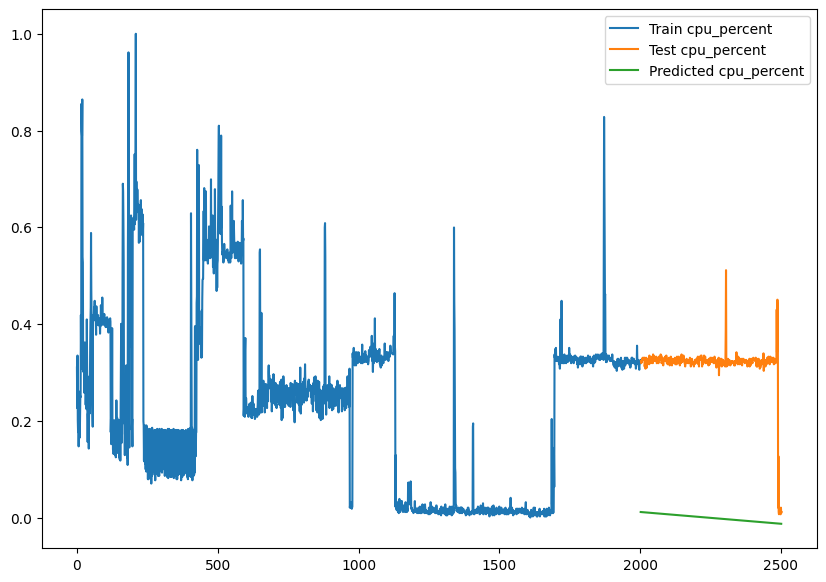

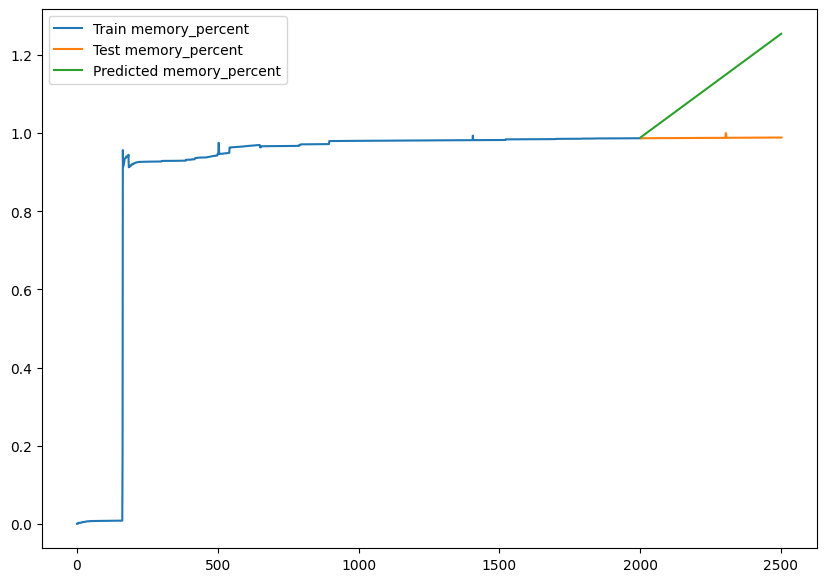

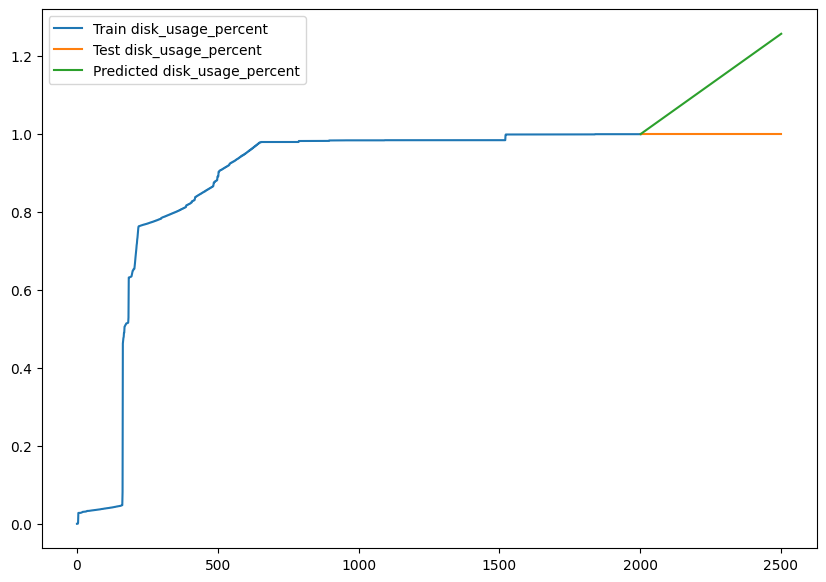

In [169]:
import matplotlib.pyplot as plt
%matplotlib inline

'''
for i in ['cpu_percent', 'cpu_user_time', 'cpu_system_time', 'cpu_idle_time',
          'cpu_iowait', 'cpu_softirq', 'cpu_numbers_of_ctx_switches',
          'cpu_numbers_of_interrupts', 'cpu_numbers_of_soft_interrupts',
          'cpu_load_runable_state', 'memory_percent', 'memory_active',
          'memory_cached', 'memory_shared', 'memory_swap_percent',
          'memory_swap_sin', 'memory_swap_sout', 'disk_usage_percent',
          'disk_read_count', 'disk_write_count', 'disk_read_time',
          'disk_write_time']:
'''

for i in ['cpu_percent','memory_percent','disk_usage_percent']:
    plt.rcParams["figure.figsize"] = [10,7]
    plt.plot( train[str(i)], label='Train '+str(i))
    plt.plot(test[str(i)], label='Test '+str(i))
    plt.plot(res[str(i)+'_1st_inv_diff'], label='Predicted '+str(i))
    plt.legend(loc='best')
    plt.show()